<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
استخرمون نشه؟</font>
</h1>

<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
مقدمه و صورت مسئله
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
در بسیاری از وب‌سایت‌های گردشگری و رزرو اقامتگاه‌ها، کاربران می‌توانند تصاویر مختلفی از اقامتگاه‌های مختلف را مشاهده کنند. در این مسئله قصد داریم با استفاده از مجموعه‌ای از تصاویر اقامتگاه‌ها، مدلی طراحی کنیم که بتواند بر اساس تحلیل تصاویر یک اقامتگاه، وجود یا عدم وجود استخر در آن اقامتگاه را پیش‌بینی کند.
</font>
</p>

<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
وارد کردن کتابخانه‌های مورد نیاز
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
    ابتدا کتابخانه‌های مورد نیازتان را وارد کنید.
</font>
</p>

In [3]:
import pandas as pd
import numpy as np
import re
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models, datasets
from torch_snippets import *
from glob import glob
import os
import clip
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import random
from transformers import CLIPProcessor, CLIPModel
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import time
import cv2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
معرفی مجموعه داده
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
مجموعه داده ارائه‌شده به صورت JSON حاوی اطلاعاتی درباره ۱۵۹۹ اقامتگاه است که شامل ویژگی‌های مختلفی می‌باشند. این مجموعه شامل یک لیست با کلید "rooms" است که اقامتگاه‌های موجود در آن قرار دارند. هر رکورد در این مجموعه داده نمایانگر یک اقامتگاه با خصوصیات و امکانات مربوط به آن است. در جدول زیر، کلیدها و توضیحات آن‌ها آورده شده‌اند.
</font>
</p>

<center>
<div dir=rtl style="direction: rtl;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>

|کلید|توضیحات|
|:------:|:---:|
|id|شناسه یکتای اقامتگاه|
|title|عنوان اقامتگاه|
|description|توضیحاتی در مورد اقامتگاه|
|province|اطلاعات استان شامل شناسه و نام استان|
|city|اطلاعات شهر شامل شناسه و نام شهر|

</font>
</div>
</center>


<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
نمونه‌ای از این داده‌ها به صورت زیر است:
</font>
</p>

```json
{
  "rooms": [
    {
      "id": 3202100,
      "title": "اجاره سوئیت در جاده جواهرده - اشکونکوه",
      "description": "این سوئیت بدون اتاق خواب با بالکنی دلباز و چشم اندازی زیبا در طبقه همکف یک ساختمان دو طبقه واقع شده است. فاصله اقامتگاه تا سوپرمارکت و نانوایی به ترتیب حدود ۵۰ و ۵۰۰ متر می باشد.",
      "province": {
        "id": "p26",
        "name": "مازندران"
      },
      "city": {
        "id": 303,
        "name": "رامسر"
      },
    },
    ...
  ]
}
```


<h2 align="right" style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
خواندن مجموعه داده
</font>
</h2>

<p dir="rtl" style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size="3">
    ابتدا نیاز است فایل‌های مجموعه‌‌ی داده را بخوانید. ویژگی‌های آموزشی در فایل <code>train.json</code> و دایرکتوری مربوط به تصاویر نمونه‌های آزمون که باید دسته‌ی آن‌ها را پیش‌بینی کنید، در فایل <code>test.json</code> ذخیره شده‌اند. در صورت نیاز می‌توانید بخشی از داده‌های آموزشی را به عنوان داده‌های اعتبارسنجی جدا کنید. توجه داشته باشید که ستون‌های <code>description</code> و <code>title</code> از داده‌های آزمون حذف شده‌اند و هدف اصلی این فایل، دسترسی به دایرکتوری تصاویر داده‌های آزمون است. دایرکتوری هر تصویر برابر با <code>id</code> هر اقامتگاه است و داخل پوشه <code>pictures</code> قرار دارد.
</font>
</p>

<p dir="rtl" style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
    <font face="vazir">
        <span style="color:orange"><b>نکته:</b></span>
        حجم فایل‌های این سوال حدود ۳.۸ گیگابایت است. در صورتی‌که بارگذاری این فایل‌ها در محیط کولب برای‌تان دشوار است می‌توانید با استفاده از دستور زیر این دو فایل را به‌صورت مستقیم در محیط کولب بارگیری کنید.
        همچنین می‌توانید از لینک درایو زیر فایل‌ها را دانلود کرده و بر روی محیط دستگاه خود از آن استفاده کنید.
    </font>
</p>

<p dir="rtl" style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
    <font face="vazir">
        <a href="https://drive.google.com/file/d/1b8O_a6ywcsbLqJAGDGCkePrdn1cFlXl0/view?usp=sharing" target="_blank" style="color:blue;">لینک دانلود از گوگل درایو</a>
    </font>
</p>





In [2]:
# # Run this cell to download directly to colab\

# # Install gdown
# !pip install gdown

# # Import necessary libraries
# import gdown
# import zipfile

# # Google Drive file ID and destination filename
# file_id = '1b8O_a6ywcsbLqJAGDGCkePrdn1cFlXl0'
# destination = 'downloaded_file.zip'

# # Download the file from Google Drive
# gdown.download(f'https://drive.google.com/uc?id={file_id}', destination, quiet=False)

# # Unpack the zip file
# with zipfile.ZipFile(destination, 'r') as zip_ref:
#     zip_ref.extractall('unzipped_content')

# print("Download and extraction complete.")


In [4]:
train_data = pd.read_json('train.json')
train_data

,rooms
0,"{'id': 3175858, 'title': 'رزرو ویلا با استخر ر..."
1,"{'id': 3237321, 'title': 'اجاره ویلا استخردار ..."
2,"{'id': 3154228, 'title': 'اجاره ویلا با استخر ..."
3,"{'id': 3169850, 'title': 'رزرو سوئیت در جواهرد..."
4,"{'id': 3207557, 'title': 'اجاره سوئیت در جاده ..."
...,...
1594,"{'id': 3167459, 'title': 'اجاره ویلا استخردار ..."
1595,"{'id': 3207406, 'title': 'اجاره ویلا استخردار ..."
1596,"{'id': 3172620, 'title': 'اجاره ویلا چابکسر - ..."
1597,"{'id': 3237948, 'title': 'اجاره سوئیت در جواهر..."


In [5]:
test_data = pd.read_json('test.json')
test_data

,rooms
0,{'id': 3160664}
1,{'id': 3195184}
2,{'id': 3224078}
3,{'id': 3233712}
4,{'id': 3201449}
...,...
856,{'id': 3232618}
857,{'id': 3230930}
858,{'id': 3171083}
859,{'id': 3168538}


<h2 align="right" style="line-height: 200%; font-family: Vazir; color: #0099cc;">
    پیش‌پردازش و مهندسی ویژگی
</h2>

<p dir="rtl" style="direction: rtl; text-align: justify; line-height: 200%; font-family: Vazir; font-size: medium;">
    در این سؤال، باید با استفاده از توصیفات و تیتر هر اقامت‌گاه، وجود یا عدم وجود استخر را استخراج کنید. می‌توانید از هر تکنیک پیش‌پردازش/مهندسی ویژگی دلخواهتان، استفاده کنید.
    <br>
    تکنیک‌هایی که استفاده می‌کنید به شکل مستقیم توسط سامانه داوری ارزیابی نمی‌شوند، بلکه همه آن‌ها بر دقت مدل شما تأثیر خواهند گذاشت. بنابراین، هرچه پیش‌پردازش و مهندسی ویژگی بهتری انجام دهید و دقت مدل بهبود یابد، امتیاز بیشتری از این سؤال کسب خواهید کرد.
</p>


In [6]:
# extract the existence of a pool from the text
train_data['rooms'][0]

{'id': 3175858,
 'title': 'رزرو ویلا با استخر روباز آبگرم در چهارباغ',
 'description': '**رزرو ویلا با استخر روباز آبگرم در چهارباغ **\nاین ویلا دو خوابه که یک اتاق خواب مستر دارد با استخر چهارفصل روباز آبگرم در حیاط دنج و باصفای ویلا مزین به آبنما، فضای سبز، آتشدان و باربیکیو در منطقه ای امن و آرام از چهارباغ واقع شده است و با شهر کرج حدود ۲۵ کیلومتر فاصله دارد.\nبام تهرانی موجود به همراه فضای حیاط دلنشین ویلا می تواند اوقات خوشی را جهت شب نشینی و بهره بردن از آب و هوای منطقه فراهم آورد.\nمحیط اطراف ویلا از چهار طرف با دیوار بلند حصارکشی شده است و یک واحد نگهبانی شبانه در کانکس موجود در محوطه کوچه مستقر می باشد.\nاز این ویلا با حدود ۳ دقیقه رانندگی دسترسی به نانوایی و سوپرمارکت امکان\u200cپذیر است.\nکیفیت خطوط شبکه برای ایرانسل و همراه اول در مکالمه عالی و پوشش اینترنت ۴g می باشد.\nلازم به ذکر است حدود ۴۰۰ متر مسیر انتهایی ویلا جاده خاکی مناسب برای عبور و مرور وسایل نقلیه می باشد.',
 'province': {'id': 'p31', 'name': 'البرز'},
 'city': {'id': 363, 'name': 'چهارباغ'}}

In [6]:
# do some preprocessing 

In [7]:
class Preprocessor():
    def __init__(self, df):
        self.df = df.copy()

    def handle_missing_value(self):
        self.df.fillna(0, inplace=True)

    def id_finder(self):
        self.df['id'] = self.df['rooms'].apply(lambda x: str(x.get('id')) if isinstance(x, dict) else None)

    def description(self):
        self.df['description'] = self.df['rooms'].apply(
            lambda x: f"{x.get('title', '')}. {x.get('description', '')}" if isinstance(x, dict) else ''
            )
        
    def column_to_drop(self):
        columns_to_drop = ['rooms']
        self.df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    def cleaning_description(self, text):
        if pd.isna(text):
            return None 
    
        text = text.strip()
    
        text = re.sub(r"<.*?>", "", text)
    
        weird_pattern = re.compile("[" 
            u"\U0001F600-\U0001F64F"  
            u"\U0001F300-\U0001F5FF"  
            u"\U0001F680-\U0001F6FF"  
            u"\U0001F1E0-\U0001F1FF"  
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U00010000-\U0010ffff"
            u"\u200d"
            u"\u2640-\u2642"
            u"\u2600-\u2B55"
            u"\u23cf"
            u"\u23e9"
            u"\u231a"
            u"\u3030"
            u"\ufe0f"
            u"\u2069"
            u"\u2066"
            u"\u200c"
            u"\u2068"
            u"\u2067"
            "]+", flags=re.UNICODE)
        text = weird_pattern.sub(r'', text)
        text = text.replace("ي", "ی").replace("ك", "ک")
        text = re.sub(r"[^\w\s\.]", "", text)
        text = re.sub(r"\d+", "", text)
        text = re.sub(r"[۰-۹]", "", text)
        text = text.lower()
        text = ' '.join([word for word in text.split() if len(word) > 1])
        text = re.sub(r"\s+", " ", text).strip()

        return text
    
    def classifier(self):
        self.df['description'] = self.df['description'].apply(self.cleaning_description)

        keywords = ['استخر', 'استخردار', 'استخری', 'استخر دار']
        self.df['label'] = self.df['description'].apply(lambda text: 1 if any(word in text for word in keywords) else 0)
        
    def transform(self):
        self.handle_missing_value()
        self.id_finder()
        self.description()
        self.column_to_drop()
        self.classifier()
        self.df.drop(columns=['description'], inplace=True)

        return self.df

In [8]:
preprocessor = Preprocessor(train_data)
df_train = preprocessor.transform()
df_train

,id,label
0,3175858,1
1,3237321,1
2,3154228,1
3,3169850,0
4,3207557,0
...,...,...
1594,3167459,1
1595,3207406,1
1596,3172620,0
1597,3237948,0


In [9]:
df_test = test_data.copy()
df_test['id'] = df_test['rooms'].apply(lambda x :str(x.get('id')) if isinstance(x, dict) else None)
df_test.drop(columns=['rooms'], inplace=True)
print(df_test['id'].isna().sum())
df_test

0


,id
0,3160664
1,3195184
2,3224078
3,3233712
4,3201449
...,...
856,3232618
857,3230930
858,3171083
859,3168538


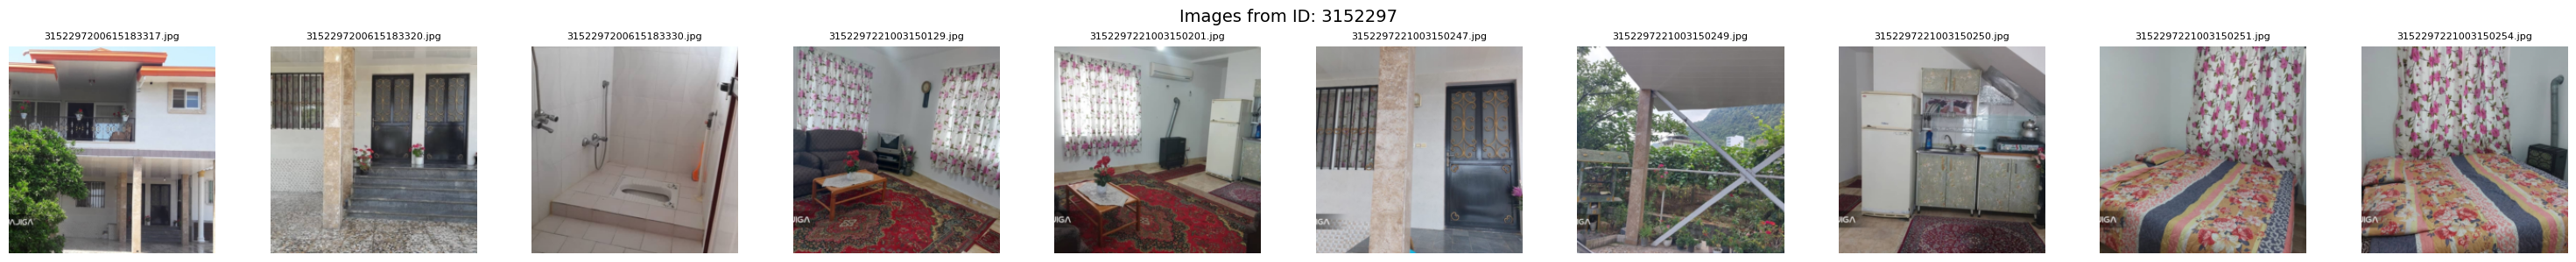

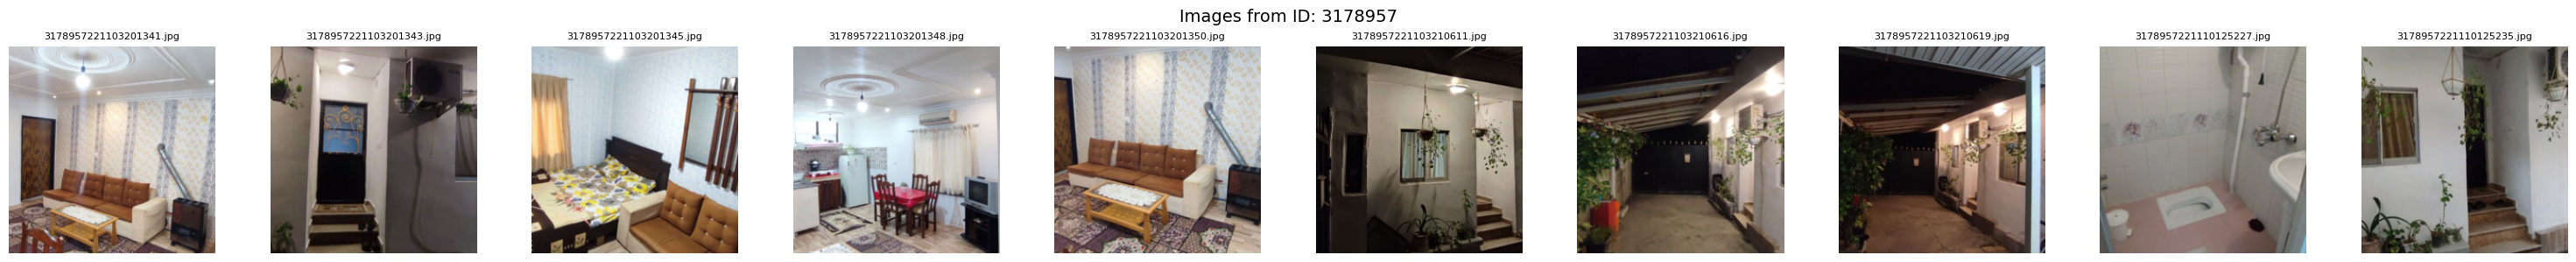

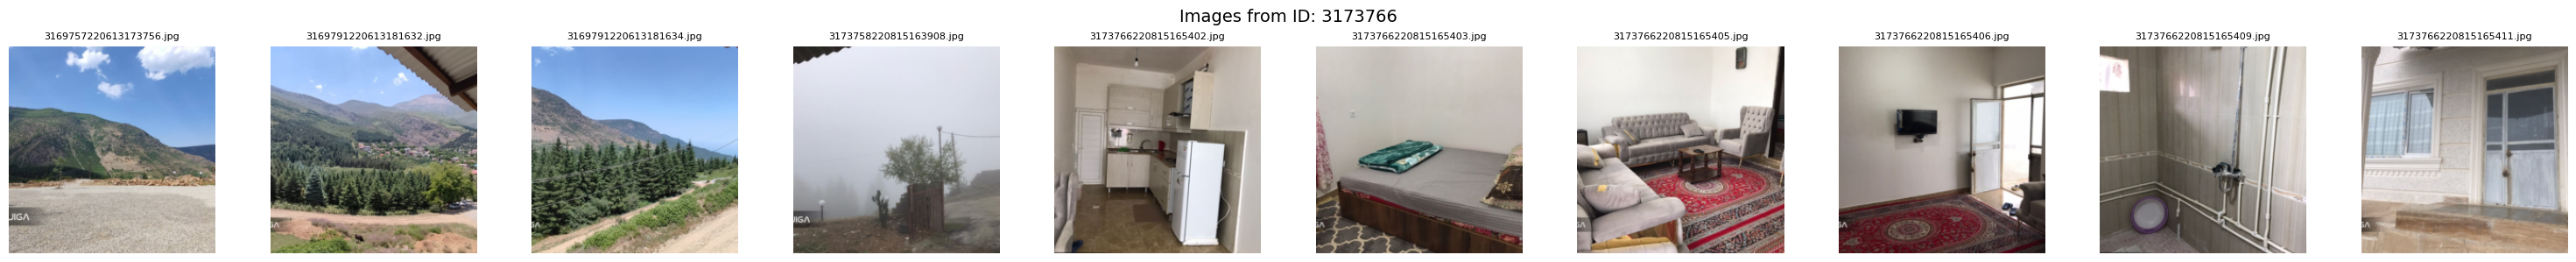

In [10]:
random_ids = df_train['id'].sample(3).tolist()
base_path = r'F:\deep_learning\pool_quera\train'

def center_crop_and_resize(img, size=(224, 224)):
    w, h = img.size
    crop_size = min(w, h)
    transform = transforms.Compose([
        transforms.CenterCrop(crop_size),
        transforms.Resize(size),
        transforms.ToTensor()
    ])
    return transform(img)

for folder_id in random_ids:
    image_paths = glob(os.path.join(base_path, folder_id, '*'))
    num_images = len(image_paths)

    if num_images == 0:
        continue

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
    fig.suptitle(f"Images from ID: {folder_id}", fontsize=14)

    if num_images == 1:
        axes = [axes]

    for ax, img_path in zip(axes, image_paths):
        try:
            img = Image.open(img_path).convert('RGB')
            img_resized = center_crop_and_resize(img)
            img_np = img_resized.permute(1, 2, 0).numpy()  # CHW → HWC
            ax.imshow(img_np)
            ax.set_title(os.path.basename(img_path), fontsize=8)
            ax.axis('off')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
مدل‌سازی
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
    حال که داده‌ها را پیش‌پردازش کرده‌اید، و دسته‌بندی وجود یا عدم وجود استخر را از متن انجام داده‌اید، وقت آن است که مدلی آموزش دهید که بتواند متغیر هدف این مسئله یعنی وجود یا عدم وجود استخر را پیش‌بینی کند.
    <br>
    شما مجاز هستید از هر مدلی که آموخته‌اید استفاده کنید. هدف این سوال پیش‌بینی هرچه بهتر متغیر هدف است! که آن همان وجود یا عدم وجود استخر است!
</font>
</p>

In [11]:
# modeling 

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device)

text_descriptions = [
    "A large rectangular swimming pool with clear blue water in a villa backyard",
    "An outdoor infinity pool overlooking a garden in a luxury villa",
    "A small circular pool with reflective water surrounded by tiles",
    "A rooftop swimming pool with city views in a modern villa",
    "A villa pool with underwater lights glowing at dusk",
    "A tropical-style pool with palm trees and clear water in a garden",

    "A lush green garden with grass and trees in a villa, no swimming pool",
    "A modern villa with a stone facade and no pool in the backyard",
    "A spacious backyard with flower beds and shrubs, without a pool",
    "The interior of a luxury villa with marble floors and no pool outside",
    "A villa with a large patio and outdoor furniture, no swimming pool",
    "A cozy garden with a wooden deck and greenery, no pool present"
]
text_tokens = clip.tokenize(text_descriptions).to(device)

def load_images_from_folder(folder_path):
    images = []
    image_paths = []
    for filename in os.listdir(folder_path):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(folder_path, filename)
            try:
                image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
                images.append(image)
                image_paths.append(img_path)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    return images, image_paths

class CLIPPoolDataset(Dataset):
    def __init__(self, df, base_path):
        self.df = df.reset_index(drop=True)
        self.base_path = base_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        folder_id = str(self.df.loc[idx, 'id'])
        label = torch.tensor(self.df.loc[idx, 'label'], dtype=torch.float32).to(device)
        folder_path = os.path.join(self.base_path, folder_id)

        images, image_paths = load_images_from_folder(folder_path)
        if not images:
            return torch.tensor([0.0]).to(device), label, folder_id, [], []

        logits = []
        all_similarities = []
        for img_idx, image in enumerate(images):
            with torch.no_grad():
                image_features = model.encode_image(image)
                image_features /= image_features.norm(dim=-1, keepdim=True)
                text_features = model.encode_text(text_tokens)
                text_features /= text_features.norm(dim=-1, keepdim=True)
                similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1).squeeze()
                pool_prob = similarity[:6].sum()
                logits.append((pool_prob, image_paths[img_idx]))
                all_similarities.append(similarity)

        if not logits:
            return torch.tensor([0.0]).to(device), label, folder_id, [], []

        max_logit, max_img_path = max(logits, key=lambda x: x[0])
        max_sim_idx = [i for i, (_, path) in enumerate(logits) if path == max_img_path][0]
        max_similarity = all_similarities[max_sim_idx]
        return max_logit.unsqueeze(0), label, folder_id, max_img_path, max_similarity

def collect_pool_image_paths(dataset, prob_threshold=0.5):
    pool_image_paths = []
    for idx in range(len(dataset)):
        max_logit, label, folder_id, max_img_path, max_similarity = dataset[idx]

        if max_logit.item() > prob_threshold:
            if isinstance(max_img_path, list) and max_img_path:
                pool_image_paths.append(max_img_path[0])
            elif isinstance(max_img_path, str):
                pool_image_paths.append(max_img_path)
            print(f"پوشه {folder_id}: استخر تشخیص داده شد با احتمال {max_logit.item():.4f}، مسیر: {max_img_path}")
        else:
            print(f"پوشه {folder_id}: استخر تشخیص داده نشد (احتمال {max_logit.item():.4f})")

    return pool_image_paths

In [ ]:
base_path = r'F:\deep_learning\pool_quera\train'
dataset = CLIPPoolDataset(df_train[df_train['label'] == 1], base_path)
prob_threshold = 0.5
pool_paths = collect_pool_image_paths(dataset, prob_threshold)

In [ ]:
selected_paths = random.sample(pool_paths, 15)

fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for i in range(3):
    for j in range(5):
        idx = i * 5 + j
        if idx < len(selected_paths):
            img_path = selected_paths[idx]
            img = mpimg.imread(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(f"Image {idx+1}")
        else:
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
base_path = r'F:\deep_learning\pool_quera\train'

df_non_pool = df_train[df_train['label'] == 0].copy()

grouped = df_non_pool.groupby('id')

non_pool_paths = []

for folder_id, _ in grouped:
    if len(non_pool_paths) < 450:
        folder_path = os.path.join(base_path, folder_id)
        if os.path.exists(folder_path):
            image_files = [f for f in os.listdir(folder_path) if f.endswith((".jpg", ".jpeg", ".png"))]
            if image_files:
                random_image = random.choice(image_files)
                image_path = os.path.join(folder_path, random_image)
                non_pool_paths.append(image_path)

non_pool_paths = non_pool_paths[:450]

In [ ]:
selected_paths = random.sample(non_pool_paths, 15)

fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for i in range(3):
    for j in range(5):
        idx = i * 5 + j
        if idx < len(selected_paths):
            img_path = selected_paths[idx]
            img = mpimg.imread(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(f"Image {idx+1}")
        else:
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#Settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 9
batch_size = 32
lr = 1e-4

#model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
clip_model.eval()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# --------- Augmentation ---------
transform = A.Compose([
    A.LongestMaxSize(max_size=256),
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.CenterCrop(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=25, p=0.5),
    A.RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), p=0.5),
    A.Blur(p=0.3),
    A.CoarseDropout(p=0.3),
    A.Normalize(
        mean=(0.48145466, 0.4578275, 0.40821073),
        std=(0.26862954, 0.26130258, 0.27577711)
    ),
    ToTensorV2(),
])
class PoolCLIPDataset(Dataset):
    def __init__(self, pool_paths, non_pool_paths, transform=None):
        self.image_paths = pool_paths + non_pool_paths
        self.labels = [1] * len(pool_paths) + [0] * len(non_pool_paths)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        label = self.labels[idx]
        image = np.array(Image.open(path).convert("RGB"))
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

class MLP(nn.Module):
    def __init__(self, in_features=768, hidden=256, out_features=2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden, out_features)
        )

    def forward(self, x):
        return self.fc(x)

combined = list(zip(pool_paths, [1]*len(pool_paths))) + list(zip(non_pool_paths, [0]*len(non_pool_paths)))
random.shuffle(combined)

split = int(0.8 * len(combined))
train_paths = [x[0] for x in combined[:split]]
train_labels = [x[1] for x in combined[:split]]
val_paths = [x[0] for x in combined[split:]]
val_labels = [x[1] for x in combined[split:]]

train_pool = [p for p, l in zip(train_paths, train_labels) if l == 1]
train_non = [p for p, l in zip(train_paths, train_labels) if l == 0]
val_pool = [p for p, l in zip(val_paths, val_labels) if l == 1]
val_non = [p for p, l in zip(val_paths, val_labels) if l == 0]

train_dataset = PoolCLIPDataset(train_pool, train_non, transform)
val_dataset = PoolCLIPDataset(val_pool, val_non, transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

clf = MLP().to(device)
optimizer = torch.optim.Adam(clf.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

#extract featchres
@torch.no_grad()
def extract_features(batch):
    return clip_model.vision_model(batch).pooler_output

#train
for epoch in range(epochs):
    clf.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start = time.time()

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            features = extract_features(images)

        outputs = clf(features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item()

        pbar.set_postfix({'loss': f"{loss.item():.4f}", 'acc': f"{correct/total:.4f}"})

    train_loss_avg = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss_avg)
    train_accuracies.append(train_acc)
    print(f"✅ Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Time: {time.time()-start:.2f}s")

    clf.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            features = extract_features(images)
            outputs = clf(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_loss_avg = val_loss / len(val_loader)
    val_losses.append(val_loss_avg)
    val_accuracies.append(val_acc)
    print(f"🔍 Val Accuracy: {val_acc:.4f} | Val Loss: {val_loss_avg:.4f}\n")

epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 5))

#Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss", marker='o')
plt.plot(epochs_range, val_losses, label="Validation Loss", marker='o')
plt.title("Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", marker='o')
plt.title("Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
@torch.no_grad()
def extract_features(batch):
    return clip_model.vision_model(batch).pooler_output

class PredictionDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        image = np.array(Image.open(path).convert("RGB"))
        if self.transform:
            image = self.transform(image=image)["image"]
        return image

def predict_image(image_path, model, clip_model, transform, device, threshold=0.5):
    dataset = PredictionDataset([image_path], transform=transform)
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    with torch.no_grad():
        for images in loader:
            images = images.to(device)
            features = extract_features(images)
            outputs = model(features)
            probabilities = nn.functional.softmax(outputs, dim=1)
            pool_probability = probabilities[0][1].item()
            return pool_probability > threshold, pool_probability
    return False, 0.0

def predict_folder(folder_path, df_row, model, clip_model, transform, device, threshold=0.5):
    folder_id = df_row['id']
    folder_base_path = os.path.join(base_path, folder_id)
    image_paths = [os.path.join(folder_base_path, f) for f in os.listdir(folder_base_path)
                   if f.endswith((".jpg", ".jpeg", ".png"))]

    if not image_paths:
        print(f"پوشه {folder_id} خالی است یا تصویر ندارد.")
        return 0

    for img_path in image_paths:
        is_pool, probability = predict_image(img_path, model, clip_model, transform, device, threshold)
        print(f"تصویر {img_path}: احتمال استخر = {probability:.4f}, پیش‌بینی = {'pool' if is_pool else 'non-pool'}")
        if is_pool:
            return 1
    return 0

def evaluate_df(df, model, clip_model, transform, device, threshold=0.5):
    predictions = []
    for index, row in tqdm(df.iterrows(), total=len(df), desc="بررسی پوشه‌ها"):
        pred = predict_folder(base_path, row, model, clip_model, transform, device, threshold)
        predictions.append(pred)
    df['predicted_label'] = predictions
    return df

df_result = evaluate_df(df_train, clf, clip_model, transform, device)

In [ ]:
df_result[df_result['label'] != df_result['predicted_label']]

In [ ]:
base_path = r'F:\deep_learning\pool_quera\train'
wrong_preds = df_result[df_result['label'] != df_result['predicted_label']]

row = wrong_preds.sample(1).iloc[0]
folder_id = row['id']
true_label = row['label']
pred_label = row['predicted_label']

folder_path = os.path.join(base_path, str(folder_id))
image_paths = sorted([
    os.path.join(folder_path, f) for f in os.listdir(folder_path)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
])

plt.figure(figsize=(len(image_paths) * 2.5, 4))
for i, img_path in enumerate(image_paths):
    img = Image.open(img_path)
    plt.subplot(1, len(image_paths), i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{i+1}", fontsize=10)

plt.suptitle(f"ID: {folder_id} | Label: {true_label} | Predicted: {pred_label}", fontsize=14)
plt.tight_layout()
plt.show()

<h3 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
معیار ارزیابی
</font>
</h3>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
    معیاری که برای ارزیابی عملکرد مدل انتخاب کرده‌ایم، <code>f1_score</code> نام دارد.
    <br>
    این معیار، سنجه ارزیابی کیفیت مدل شماست. به عبارت بهتر در سامانه داوری هم از همین معیار برای نمره‌دهی استفاده شده است.
    <br>
    پیشنهاد می‌شود با توجه به این معیار، عملکرد مدل خود را بر روی مجموعه داده آموزش یا اعتبارسنجی ارزیابی کنید.
    
</font>
</p>

In [ ]:
# evaluate model
from sklearn.metrics import  f1_score, classification_report, confusion_matrix


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
 پیش‌بینی برای داده تست و خروجی
</font>
</h2>

<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    پس از مهندسی ویژگی و مدلسازی، الگوریتمی دارید که می‌تواند شما را از متغیرهای مستقل به متغیر هدف برساند.
    <br>
    از این مدل برای پیش‌بینی نمونه‌های موجود در داده تست استفاده کنید و نتایج را در قالب جدول (<code>dataframe</code>) زیر آماده کنید.
</font>
</p>

<div dir=rtl style="direction: rtl;text-align: center;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    
|ستون|توضیحات|
|------|---|
|Pool|وجود یا عدم وجود استخر|
|id|شناسه یکتای اقامتگاه|
    
</font>
</div>



<p dir="rtl" style="direction: rtl; text-align: justify; line-height: 200%; font-family: Vazir; font-size: medium;">
    نام دیتافریم باید <i>submission</i> باشد؛ در غیر این صورت، سامانه داوری نمی‌تواند تلاش شما را ارزیابی کند.
    <br>
    این دیتافریم شامل دو ستون با نام‌های <i>id</i> و <i>Pool</i> است و دارای ۸۶۲ سطر می‌باشد.
    <br>
    مقادیر موجود در ستون <i>Pool</i> شامل <i>True</i> یا <i>False</i> هستند.
    <br>
    برای هر سطر موجود در دیتافریم <i>test</i> باید یک مقدار پیش‌بینی‌شده داشته باشید.
    <br>
    جدول زیر، ۵ سطر ابتدایی دیتافریم <code>submission</code> را نشان می‌دهد. البته در جواب شما، مقادیر ستون <i>Pool</i> ممکن است متفاوت باشد.
</p>

<div style="text-align: center; line-height: 200%; font-family: Vazir; font-size: medium;">
    <font face="vazir" size="3">
        <table border="1" style="margin: 0 auto;">
            <tr>
                <th>id</th>
                <th>Pool</th>
            </tr>
            <tr>
                <td>3160664</td>
                <td>True</td>
            </tr>
            <tr>
                <td>3195184</td>
                <td>False</td>
            </tr>
            <tr>
                <td>3224078</td>
                <td>False</td>
            </tr>
            <tr>
                <td>3233712</td>
                <td>True</td>
            </tr>
            <tr>
                <td>3201449</td>
                <td>True</td>
            </tr>
        </table>
    </font>
</div>

In [ ]:
base_path = r'F:\deep_learning\pool_quera\test'
def predict_test_df(df, model, clip_model, transform, device, threshold=0.5):
    pool_predictions = []

    for index, row in tqdm(df.iterrows(), total=len(df), desc="پیش‌بینی روی داده تست"):
        folder_id = row['id']
        folder_base_path = os.path.join(base_path, folder_id)
        image_paths = [os.path.join(folder_base_path, f) for f in os.listdir(folder_base_path)
                       if f.lower().endswith((".jpg", ".jpeg", ".png"))]

        if not image_paths:
            print(f"پوشه {folder_id} خالی است یا تصویر ندارد.")
            pool_predictions.append(False)
            continue

        is_pool = False
        for img_path in image_paths:
            pred, _ = predict_image(img_path, model, clip_model, transform, device, threshold)
            if pred:
                is_pool = True
                break
        pool_predictions.append(is_pool)

    df = df.copy()
    df["pool"] = pool_predictions
    return df

In [ ]:
df_test_result = predict_test_df(df_test, clf, clip_model, transform, device)
df_test_result

In [ ]:
# predict test samples
submission = df_test_result
submission


<h2 dir=rtl align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
<b>سلول جواب‌ساز</b>
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
    برای ساخته‌شدن فایل <code>result.zip</code> سلول زیر را اجرا کنید. توجه داشته باشید که پیش از اجرای سلول زیر تغییرات اعمال شده در نت‌بوک را ذخیره کرده باشید (<code>ctrl+s</code>) در غیر این صورت، در پایان مسابقه نمره شما به صفر تغییر خواهد کرد.
    <br>
    همچنین اگر از کولب برای اجرای این فایل نوت‌بوک استفاده می‌کنید، قبل از ارسال فایل <code>result.zip</code>، آخرین نسخه‌ی نوت‌بوک خود را دانلود کرده و داخل فایل ارسالی قرار دهید.
</font>

In [ ]:
import zipfile
import joblib

if not os.path.exists(os.path.join(os.getcwd(), 'EstakhtemoonNasheh.ipynb')):
    %notebook -e EstakhtemoonNasheh.ipynb

def compress(file_names):
    print("File Paths:")
    print(file_names)
    compression = zipfile.ZIP_DEFLATED
    with zipfile.ZipFile("result.zip", mode="w") as zf:
        for file_name in file_names:
            zf.write('./' + file_name, file_name, compress_type=compression)
            
submission.to_csv('submission.csv', index=False)
file_names = ['EstakhtemoonNasheh.ipynb', 'submission.csv']
compress(file_names)